In [177]:
# Jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


early stopping at iter:3635
early stopping at iter:3156
early stopping at iter:3834
early stopping at iter:3607
early stopping at iter:3959


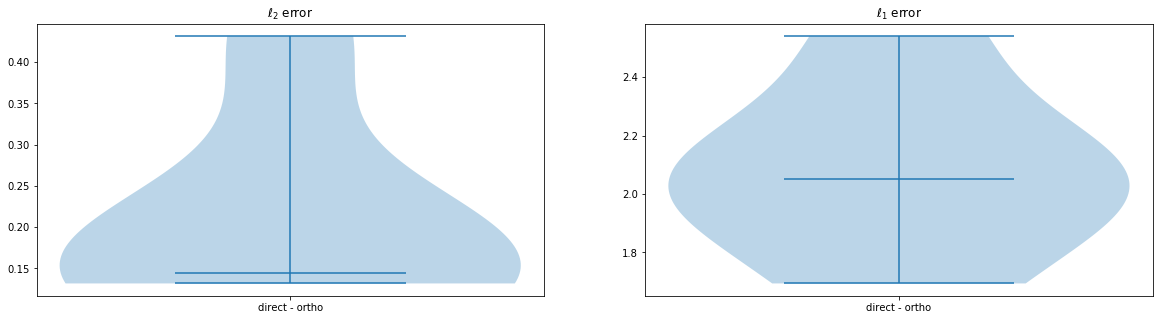

In [179]:
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskLassoCV, LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from logistic_te import gen_data, direct_fit, dml_fit


def main():
    n_samples = 5000 # samples used for estimation
    dim_x = 50 # dimension of controls x
    dim_z = 50 # dimension of variables used for heterogeneity (subset of x)
    kappa_x = 25 # support size of control function
    kappa_theta = 1 # support size of target parameter
    sigma_eta = 5 # variance of error in secondary moment equation
    lambda_coef = 1 # coeficient in front of the asymptotic rate for regularization lambda

    l2_direct = []
    l2_ortho = []
    l2_cross_ortho = []
    l1_direct = []
    l1_ortho = []
    l1_cross_ortho = []
    for _ in range(5):
        # Generate data
        x, t, z, y, support_x, support_theta, alpha_x, beta_x, theta =\
                gen_data(n_samples, dim_x, dim_z, kappa_x, kappa_theta, sigma_eta)
        true_coef = np.zeros((dim_z, 1))
        true_coef[support_theta] = theta
        
        
        # Direct lasso for all coefficients
        model_y, model_t= direct_fit(x, t, z, y)
        l1_direct.append(np.linalg.norm(model_y.coef_.flatten()[:z.shape[1]] - true_coef.flatten(), ord=1))
        l2_direct.append(np.linalg.norm(model_y.coef_.flatten()[:z.shape[1]].flatten() - true_coef.flatten(), ord=2))
        
        # Orthogonal lasso estimation
        ortho_coef = dml_fit(x, t, z, y)
        l1_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=1))
        l2_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=2))


    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.violinplot([np.array(l2_direct) - np.array(l2_ortho)], showmedians=True)
    plt.xticks([1], ['direct - ortho'])
    plt.title('$\ell_2$ error')
    plt.subplot(1,2,2)
    plt.violinplot([np.array(l1_direct) - np.array(l1_ortho)], showmedians=True)
    plt.xticks([1], ['direct - ortho'])
    plt.title('$\ell_1$ error')
    plt.show()
    
main()